# Data upload

In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gzip

directory = os.getcwd()
data_path = os.path.join(directory, 'Data')

# Definining the path for the files
RB_path = os.path.join(data_path, 'RateBeer')
BA_path = os.path.join(data_path, 'BeerAdvocate')
MB_path = os.path.join(data_path, 'matched_beer_data')

# Extraction of the data and preprocessing of the files

In [3]:
# List the .tar files in the source directory and extract them in the corresponding subfolder
tar_files = [file for file in os.listdir(data_path) if file.endswith('.gz')]

for tar_file in tar_files:
    tar_file_path = os.path.join(data_path, tar_file)

    extraction_folder_name = os.path.basename(tar_file_path).split('.', 1)[0]
    folder_path = os.path.join(data_path, extraction_folder_name)
    os.makedirs(folder_path, exist_ok=True)

    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(path=folder_path)

In [4]:
def text_to_csv(path, filename):
    '''
        This function takes as input the path where the .txt file is located as well as the filename and will create a .tsv file 
        in the same folder from the data in the .txt file. 
        
        The .txt file is read line by line and a dictionary is created to which the different values for each key are appended as 
        the file is read. The "nan" are replaced by empty space ('') to be better recognized when creating a dataframe.
    '''
    main_path = os.path.join(path, filename)
    if not os.path.exists(main_path + '.tsv'):
        with gzip.open(main_path + '.txt.gz', 'rt', encoding="utf8") as file_txt:
            with open(main_path + '.tsv', 'w', encoding="utf8") as file_tsv:
                first = True
                obj = {}
                for line in file_txt:
                    if line == '\n':
                        if first:
                            file_tsv.write("\t".join(obj.keys()) + "\n")
                            first=False
                        file_tsv.write("\t".join(obj.values()) + "\n")
                        obj = {}
                        continue

                    line = re.sub(r'\bnan\b', '', line)
                    key, value = line.strip().split(":", 1)
                    obj[key] = value
                
                if obj: file_tsv.write("\t".join(obj.values()) + "\n")

In [5]:
#Transformation of the .txt files
text_to_csv(RB_path, 'ratings')
text_to_csv(RB_path, 'reviews')

text_to_csv(BA_path, 'ratings')
text_to_csv(BA_path, 'reviews')

text_to_csv(MB_path, 'ratings_ba')
text_to_csv(MB_path, 'ratings_with_text_ba')
text_to_csv(MB_path, 'ratings_rb')
text_to_csv(MB_path, 'ratings_with_text_rb')

# Creation of dataframes

Matching data:

In [6]:
MB_beers = pd.read_csv(MB_path + '/beers.csv', header=1)
MB_breweries = pd.read_csv(MB_path + '/breweries.csv', header=1)
MB_users = pd.read_csv(MB_path + '/users.csv', header=1)
MB_users_approx = pd.read_csv(MB_path + '/users_approx.csv', header=1)

In [7]:
MB_ratings = pd.read_csv(MB_path + '/ratings.csv', header=1)
MB_ratingsBA = pd.read_csv(MB_path + '/ratings_ba.tsv', sep='\t')
MB_ratingsBA_txt = pd.read_csv(MB_path + '/ratings_with_text_ba.tsv', sep='\t')
MB_ratingsRB = pd.read_csv(MB_path + '/ratings_rb.tsv', sep='\t')
MB_ratingsRB_txt = pd.read_csv(MB_path + '/ratings_with_text_rb.tsv', sep='\t')

Rest of the data:

In [ ]:
# Assigning variables
RB_beers = pd.read_csv(RB_path + '/beers.csv')
RB_breweries = pd.read_csv(RB_path + '/breweries.csv')
RB_users = pd.read_csv(RB_path + '/users.csv')
RB_ratings = pd.read_csv(RB_path + '/ratings.tsv', sep='\t')
RB_reviews = pd.read_csv(RB_path + '/reviews.tsv', sep='\t')



In [ ]:
BA_beers = pd.read_csv(BA_path + '/beers.csv')
BA_breweries = pd.read_csv(BA_path + '/breweries.csv')
BA_users = pd.read_csv(BA_path + '/users.csv')
BA_ratings = pd.read_csv(BA_path + '/ratings.tsv', sep='\t')
BA_reviews = pd.read_csv(BA_path + '/reviews.tsv', sep='\t')


# Popularity analysis over time

The rationale behind this idea is to be able to match or provide fun facts to the users of our social network about which would have been the perfect year for them to live in according to their preferences.

Doing a time analysis of beer popularity over time, we will be using the matched dataset since we are not considering a comparison between BeerAdvocate and RateBeer but uncovering trends in beers over the years. According to the article by G. Lederrey and R. West (https://doi.org/10.1145/3178876.3186160), the matched set has gone through internal and external validity in terms of being unbiased with respect to countries and beer style distributions and rating being "approximately independent of site and product properties".

However, in order to analyze the top ranked beers for each year, we would need to consider the herding effect. In other words, if for a certain year there is a larger number of ratings coming from the database that has being positively impacted by the herding effect, the average in rating will be higher than in the opposite case. Also, the herding effect although continuing to be present, has a higher effect when the number of ratings for the beer is lower.

Thus, we will start by analyzing the distribution of the number of ratings for each bear to discard the beers with a very low number of ratings. Then, dividing the beers into 3 groups (small = S, medium = M and large = L) according to the number of ratings, we will perform the relative ratios from the first review in each webpage and the review n, to quantify the hearding effect and perform detrending before computing the macro-average to determine the top 3 ranked beers per year.

In [8]:
print(MB_beers.shape)
print(MB_ratings.shape)

(45640, 33)
(21964, 33)


In [9]:
MB_beers.columns.unique()

Index(['abv', 'avg', 'avg_computed', 'avg_matched_valid_ratings', 'ba_score',
       'beer_id', 'beer_name', 'beer_wout_brewery_name', 'brewery_id',
       'brewery_name', 'bros_score', 'nbr_matched_valid_ratings',
       'nbr_ratings', 'nbr_reviews', 'style', 'zscore', 'abv.1', 'avg.1',
       'avg_computed.1', 'avg_matched_valid_ratings.1', 'beer_id.1',
       'beer_name.1', 'beer_wout_brewery_name.1', 'brewery_id.1',
       'brewery_name.1', 'nbr_matched_valid_ratings.1', 'nbr_ratings.1',
       'overall_score', 'style.1', 'style_score', 'zscore.1', 'diff', 'sim'],
      dtype='object')

In [10]:
columns_to_keep = ['beer_id', 'beer_name','beer_id.1','beer_name.1','nbr_ratings', 'nbr_ratings.1', 'style', 'style.1','diff','sim']

# keep the specified columns
MB_beers_filtered = MB_beers.filter(columns_to_keep)

In [11]:
MB_beers_filtered

,beer_id,beer_name,beer_id.1,beer_name.1,nbr_ratings,nbr_ratings.1,style,style.1,diff,sim
0,19827,Legbiter,37923,Strangford Lough Legbiter,75,89,English Pale Ale,Golden Ale/Blond Ale,1.000000,1.0
1,20841,St. Patrick's Ale,41286,Strangford Lough St. Patricks Ale,8,11,English Pale Ale,Irish Ale,0.527141,1.0
2,20842,St. Patrick's Best,41287,Strangford Lough St. Patricks Best,64,74,English Bitter,Bitter,0.527141,1.0
3,22659,St. Patrick's Gold,41285,Strangford Lough St. Patricks Gold,1,4,American Pale Wheat Ale,Amber Ale,0.527141,1.0
4,178681,Sheelin Stout,230283,Sheelin Stout,0,2,Irish Dry Stout,Mild Ale,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
45635,96911,Pale Ale,242782,Do Can Pale Ale,4,1,English Pale Ale,India Pale Ale (IPA),1.000000,1.0
45636,37457,Mustang Gold Ale,68764,Warbird Mustang Gold Ale,22,57,American Blonde Ale,Golden Ale/Blond Ale,0.806680,1.0
45637,47287,Shanty Irish,76984,Warbird Shanty Irish,10,50,Irish Red Ale,Irish Ale,1.000000,1.0
45638,37177,Thunderbolt Wheat,78298,Warbird Thunderbolt Wheat,21,59,Hefeweizen,German Hefeweizen,1.000000,1.0


<Axes: ylabel='Frequency'>

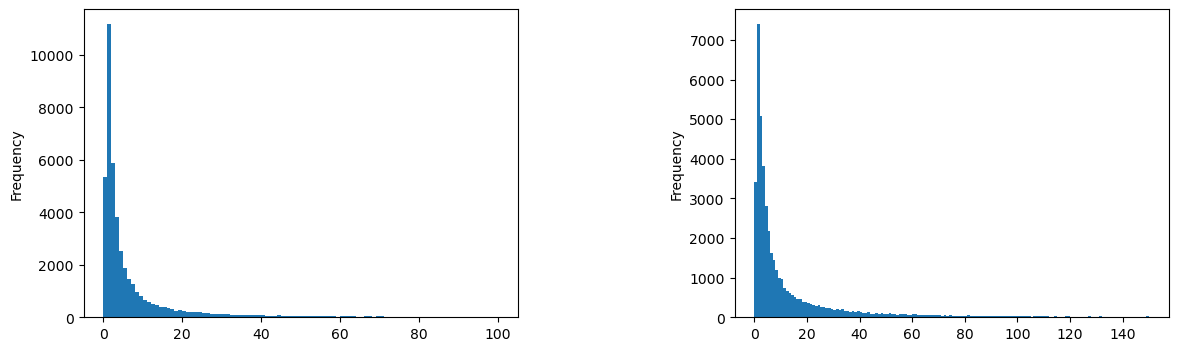

In [12]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

MB_beers_filtered['nbr_ratings'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[0])
MB_beers_filtered['nbr_ratings.1'].sort_values().plot(kind='hist', range = (0, 150), bins= 150, ax=axs[1])

In [13]:
MB_beers_filtered.nbr_ratings.describe()

count    45640.000000
mean        20.945837
std        137.768038
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       9228.000000
Name: nbr_ratings, dtype: float64

In [14]:
MB_beers['nbr_ratings.1'].describe()

count    45640.000000
mean        22.362796
std         80.107455
min          0.000000
25%          2.000000
50%          5.000000
75%         16.000000
max       5272.000000
Name: nbr_ratings.1, dtype: float64

Seeing this basic statistics and having observed the histograms we will filter out so that we keep beers with at least 5 reviews for both columns 'nbr_ratings' and 'nbr_ratings_1'. This will later help us in dimishing the **herding effect**.

In [19]:
filt_MB_beers = MB_beers_filtered[(MB_beers_filtered['nbr_ratings'] >= 5) & (MB_beers_filtered['nbr_ratings.1'] >= 5)].copy(deep=True) 

Fig. 6 in the previously mentioned paper, shows that the herding effect, although never converging to 0, becomes stable with a larger number of ratings with respect to the first one. Thus, we will keep the beers with at least 5 ratings. Note that 5 is the median value of the number of ratings. However, discarding these samples still leaves us with a large amount of data (23112 beers).
Then, we will devide the data into 3 groups, trying to make groups with a similar amount of data (BE CAREFUL WITH THIS, NOT TRUE). Thus, refering to the new tertiales.

NEED TO REORDER THIS: 

In [20]:
filt_MB_beers

,beer_id,beer_name,beer_id.1,beer_name.1,nbr_ratings,nbr_ratings.1,style,style.1,diff,sim
0,19827,Legbiter,37923,Strangford Lough Legbiter,75,89,English Pale Ale,Golden Ale/Blond Ale,1.000000,1.0
1,20841,St. Patrick's Ale,41286,Strangford Lough St. Patricks Ale,8,11,English Pale Ale,Irish Ale,0.527141,1.0
2,20842,St. Patrick's Best,41287,Strangford Lough St. Patricks Best,64,74,English Bitter,Bitter,0.527141,1.0
13,126800,Fulcrum,237641,Clearsky Fulcrum,5,21,Hefeweizen,Wheat Ale,1.000000,1.0
19,137190,India Export Porter,263238,Farmageddon India Export Porter,5,38,English Porter,Imperial Porter,0.660448,1.0
...,...,...,...,...,...,...,...,...,...,...
45633,99539,Imperial Destroyer IPA,242767,Do Can Imperial Destroyer IPA,12,5,American Double / Imperial IPA,Imperial IPA,0.647901,1.0
45636,37457,Mustang Gold Ale,68764,Warbird Mustang Gold Ale,22,57,American Blonde Ale,Golden Ale/Blond Ale,0.806680,1.0
45637,47287,Shanty Irish,76984,Warbird Shanty Irish,10,50,Irish Red Ale,Irish Ale,1.000000,1.0
45638,37177,Thunderbolt Wheat,78298,Warbird Thunderbolt Wheat,21,59,Hefeweizen,German Hefeweizen,1.000000,1.0


In [33]:
filt_MB_beers.nbr_ratings.describe()

count    12890.000000
mean        67.800155
std        253.205677
min          5.000000
25%          9.000000
50%         18.000000
75%         44.000000
max       9228.000000
Name: nbr_ratings, dtype: float64

In [40]:
display(filt_MB_beers['nbr_ratings'].quantile([0.33, 0.67]))
filt_MB_beers['nbr_ratings.1'].quantile([0.33, 0.67])

0.33    11.0
0.67    31.0
Name: nbr_ratings, dtype: float64

0.33    11.0
0.67    36.0
Name: nbr_ratings.1, dtype: float64

Now, we will do a scatter plot for each beer (in different colors) to see the trend in the herding effect. We will quantize the effect as the relation with respect to the average of the previous ratings. Note that this graph will be measured up until the minimum number of ratings used to determine the partition in the previous step (since this is the assured number of ratings that all the beers in the group will have).

In [24]:
MB_ratings.date

0        1324810800
1        1322650800
2        1344074400
3        1344074400
4        1346234400
            ...    
21959    1323946800
21960    1484046000
21961    1393239600
21962    1419764400
21963    1272794400
Name: date, Length: 21964, dtype: int64

In [25]:
MB_ratings['date'] = pd.to_datetime(MB_ratings.date, unit='s')
MB_ratings['year'] = MB_ratings['date'].dt.year


In [26]:
columns_to_keep1 = ['beer_id', 'beer_name','beer_id.1','beer_name.1','date', 'rating', 'rating.1', 'user_id','user_id.1','year']
# keep the specified columns
MB_ratings_filtered = MB_ratings.filter(columns_to_keep1)

In [27]:
ratings_beers = pd.merge(filt_MB_beers,MB_ratings_filtered, how='right')
ratings_beers

,beer_id,beer_name,beer_id.1,beer_name.1,nbr_ratings,nbr_ratings.1,style,style.1,diff,sim,date,rating,rating.1,user_id,user_id.1,year
0,645,Trappistes Rochefort 10,2360,Rochefort Trappistes 10,9228.0,5272.0,Quadrupel (Quad),Abt/Quadrupel,0.491458,1.000000,2011-12-25 11:00:00,4.80,4.6,erzengel.248045,83106,2011
1,28191,Myanmar Lager Beer,17109,Myanmar Lager Beer,32.0,135.0,American Adjunct Lager,Pale Lager,1.000000,1.000000,2011-11-30 11:00:00,3.00,1.7,visionthing.639993,91324,2011
2,57911,Cantillon Tyrnilambic Baie D’Argousier Lambic,35298,Cantillon Tyrnilambic Baie dArgousier,21.0,82.0,Lambic - Fruit,Lambic Style - Fruit,0.955451,0.955451,2012-08-04 10:00:00,3.85,4.1,tiong.608427,98624,2012
3,57913,Cantillon Pikkulinnun Viskilambic,113596,Cantillon Pikkulinnun Viskilambic,29.0,65.0,Lambic - Unblended,Lambic Style - Unblended,1.000000,1.000000,2012-08-04 10:00:00,3.68,4.1,tiong.608427,98624,2012
4,81125,Drie Fonteinen Oude Geuze - Armand & Tommy,173481,3 Fonteinen Oude Geuze (Armand & Tommy),313.0,323.0,Gueuze,Lambic Style - Gueuze,0.486129,0.969713,2012-08-29 10:00:00,4.00,4.0,tiong.608427,98624,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21959,28030,Valeir Divers,56990,Contreras Valeir Divers,48.0,149.0,Tripel,Abbey Tripel,0.605746,1.000000,2011-12-15 11:00:00,3.91,3.7,thebeerwatcher.630107,137922,2011
21960,5057,Fantôme Saison,7661,Fantôme Saison,1957.0,1193.0,Saison / Farmhouse Ale,Saison,0.483939,1.000000,2017-01-10 11:00:00,4.08,4.0,jonj.982265,394232,2017
21961,349,Jupiler,8042,Jupiler,316.0,766.0,Euro Pale Lager,Pale Lager,0.515024,1.000000,2014-02-24 11:00:00,3.00,1.2,maxilouis.784601,304802,2014
21962,127162,Redenaar,248989,dOude Maalderij Redenaar,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-28 11:00:00,2.88,3.9,simoen.728327,276666,2014


NOT EQUALLY DISTRIBUTED AMOUNT OF DATA. I AM NOT FOLLOWING WHY WE ARE DIVIDING THE DATA WITH THESE VALUES. FOR ME ACCORDING TO THE STATISTICS FROM
filt_MB_beers.nbr_ratings.describe()
IT SHOULD BE: BELOW 18, BETWEEN 18 AND 44 AND MORE THAN 44

In [34]:
S_ratingbeers = ratings_beers[(ratings_beers.nbr_ratings <= 18) & (ratings_beers['nbr_ratings.1'] <= 18)].copy(deep=True)
M_ratingbeers = ratings_beers[(ratings_beers.nbr_ratings.between(18,44)) & (ratings_beers['nbr_ratings.1'].between(18,44))].copy(deep=True) 
L_ratingbeers = ratings_beers[(ratings_beers.nbr_ratings > 18) & (ratings_beers['nbr_ratings.1'] > 44)].copy(deep=True) 

NOT EVEN LIKE THIS WE HAVE AN EQUAL DISTRIBUTION:

In [39]:
display(S_ratingbeers.shape)
display(M_ratingbeers.shape)
L_ratingbeers.shape

(991, 16)

(682, 16)

(13210, 16)

In [84]:

first_ratings = ratings_beers.sort_values(by='date').groupby('beer_name').head(1)
first_ratings
#double check that it is correct: M_ratingbeers.beer_name.nunique()

,beer_id,beer_name,beer_id.1,beer_name.1,nbr_ratings,nbr_ratings.1,style,style.1,diff,sim,date,rating,rating.1,user_id,user_id.1,year
17825,750,Carib Lager,3059,Carib Lager,440.0,678.0,American Adjunct Lager,Pale Lager,0.422058,1.000000,2001-03-09 11:00:00,1.06,0.5,brent.42,1603,2001
17828,1251,Black Jack Porter,431,Left Hand Black Jack Porter,1377.0,1205.0,English Porter,Porter,0.609322,1.000000,2001-08-17 10:00:00,2.60,2.1,brent.42,1603,2001
17826,1315,Genuine Dark Beer,7018,Berghoff Genuine Dark Beer,93.0,246.0,Euro Dark Lager,Amber Lager/Vienna,0.593796,0.925762,2001-08-21 10:00:00,3.06,3.1,brent.42,1603,2001
17824,1385,Delirium Tremens,1039,Delirium Tremens,5746.0,3357.0,Belgian Strong Pale Ale,Belgian Strong Ale,0.645682,1.000000,2001-09-02 10:00:00,4.70,3.8,brent.42,1603,2001
17827,779,Weihenstephaner Korbinian,7823,Weihenstephaner Korbinian,2666.0,1709.0,Doppelbock,Doppelbock,0.906823,1.000000,2001-09-12 10:00:00,4.84,4.3,brent.42,1603,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,202131,High Rock Red Ale,397787,New Sarum High Rock Red Ale,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-25 10:00:00,3.53,3.1,chinchill.199175,114306,2017
14310,7734,Saint-Monon Ambrée,5372,Saint-Monon Ambrée,11.0,117.0,Belgian Pale Ale,Belgian Ale,0.403914,1.000000,2017-07-28 10:00:00,3.45,3.2,ciocanelu.691982,274310,2017
15556,181472,Passe-Partout,328986,De Dochter van de Korenaar Passe-Partout,16.0,135.0,American IPA,Session IPA,1.000000,1.000000,2017-07-29 10:00:00,3.81,3.8,superspak.456300,105791,2017
15947,152629,Big Barley Wine,313343,Zaftig BIG Barley Wine,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-29 10:00:00,3.90,3.9,superspak.456300,105791,2017


In [87]:
#IMO THE NEXT STEP WOULD BE CALCULATING THE MEAN RATING IN EACH OF THE SML(3) GROUPS AND THEN COMPARING THE RATIO:
rest_ratings = ratings_beers.rating.groupby('beer_name').mean()

KeyError: 'beer_name'